<h2 align=center><font size = 5>Applied Data Science Capstone</font></h2>

<h2 align=center><font size = 5>Capstone Project - The Battle of Neighborhoods 2020</font></h2>

<center><b>Identifying the most Ideal location in Toronto to set up a New Business Venture

In [1]:
import requests #library for data analsysis

import lxml.html as lh
import bs4 as bs
import urllib.request

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files


from geopy.geocoders import Nominatim 
GeoLocator = Nominatim(user_agent='My-IBMNotebook')# convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
## Source URL 
url   = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

In [3]:
# BS4, passed to scrape_table_bs4
# create colums <tableClassName> <expected numberOfColumns>

def scrape_table_bs4(cname,cols):
    page  = urllib.request.urlopen(url).read()
    soup  = bs.BeautifulSoup(page,'lxml')
    table = soup.find("table",class_=cname)
    header = [head.findAll(text=True)[0].strip() for head in table.find_all("th")]
    data   = [[td.findAll(text=True)[0].strip() for td in tr.find_all("td")]
              for tr in table.find_all("tr")]
    data    = [row for row in data if len(row) == cols]
    # Store data to this temporary dataframe
    raw_df = pd.DataFrame(data,columns=header)
    return raw_df

# Parsing using xpath.
def scrape_table_lxml(XPATH,cols):
    page = requests.get(url)
    doc = lh.fromstring(page.content)
    table_content = doc.xpath(XPATH)
    for table in table_content:
        headers = [th.text_content().strip() for th in table.xpath('//th')]
        headers = headers[0:3]
        data    = [[td.text_content().strip() for td in tr.xpath('td')] 
                   for tr in table.xpath('//tbody/tr')]
        data    = [row for row in data if len(row) == cols]
        raw_df = pd.DataFrame(data,columns=headers)
        return raw_df

In [4]:
#Call functional scope test in beautifulSoup
raw_TorontoPostalCodes = scrape_table_bs4("wikitable",3)

#Test in lxml ( for xpath based extraction)
#raw_TorontoPostalCodes = scrape_table_lxml("/html/body/div[3]/div[3]/div[4]/div/table[1]",3)

print("# Toronto Postal codes stored in data")
print(raw_TorontoPostalCodes.info(verbose=True))

# Toronto Postal codes stored in data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Postal code   180 non-null    object
 1   Borough       180 non-null    object
 2   Neighborhood  180 non-null    object
dtypes: object(3)
memory usage: 4.3+ KB
None


<center><b> Data Prepocessing and Transformation:
<p><b>This section will focus on the data methodologies that we will try to use to solve the problem and talk about their sources. Data is never clearn, so our scraped data table from wiki contains some un-wanted entries and needs some cleaning up.</p>

In [5]:
TorontoPostalCodes=raw_TorontoPostalCodes[~raw_TorontoPostalCodes['Borough'].isin(['Not assigned'])]

# Sort and Reset index in the table.
TorontoPostalCodes=TorontoPostalCodes.sort_values(by=['Postal code','Borough','Neighborhood'], ascending=[1,1,1]).reset_index(drop=True)

TorontoPostalCodes.loc[TorontoPostalCodes['Neighborhood'] == 'Not assigned', ['Neighborhood']] = TorontoPostalCodes['Borough']
check_unassigned_post_state_sample = TorontoPostalCodes.loc[TorontoPostalCodes['Borough'] == 'Queen\'s Park']

TorontoPostalCodes = TorontoPostalCodes.groupby(['Postal code','Borough'])['Neighborhood'].apply(', '.join).reset_index()

In [6]:
TorontoPostalCodes.head()

,Postal code,Borough,Neighborhood
0,M1B,Scarborough,Malvern / Rouge
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek
2,M1E,Scarborough,Guildwood / Morningside / West Hill
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [7]:
TorontoPostalCodes.describe()

,Postal code,Borough,Neighborhood
count,103,103,103
unique,103,10,98
top,M6J,North York,Downsview
freq,1,24,4


In [30]:
tpcN = TorontoPostalCodes['Neighborhood'].value_counts()
tcpB = TorontoPostalCodes['Borough'].value_counts()

<center><b> Data Visualisation:
                  <p><b>This section will focus on visualising the unique values posessed by both neighborhood and borough.
    </p>

Text(0, 0.5, 'Counts')

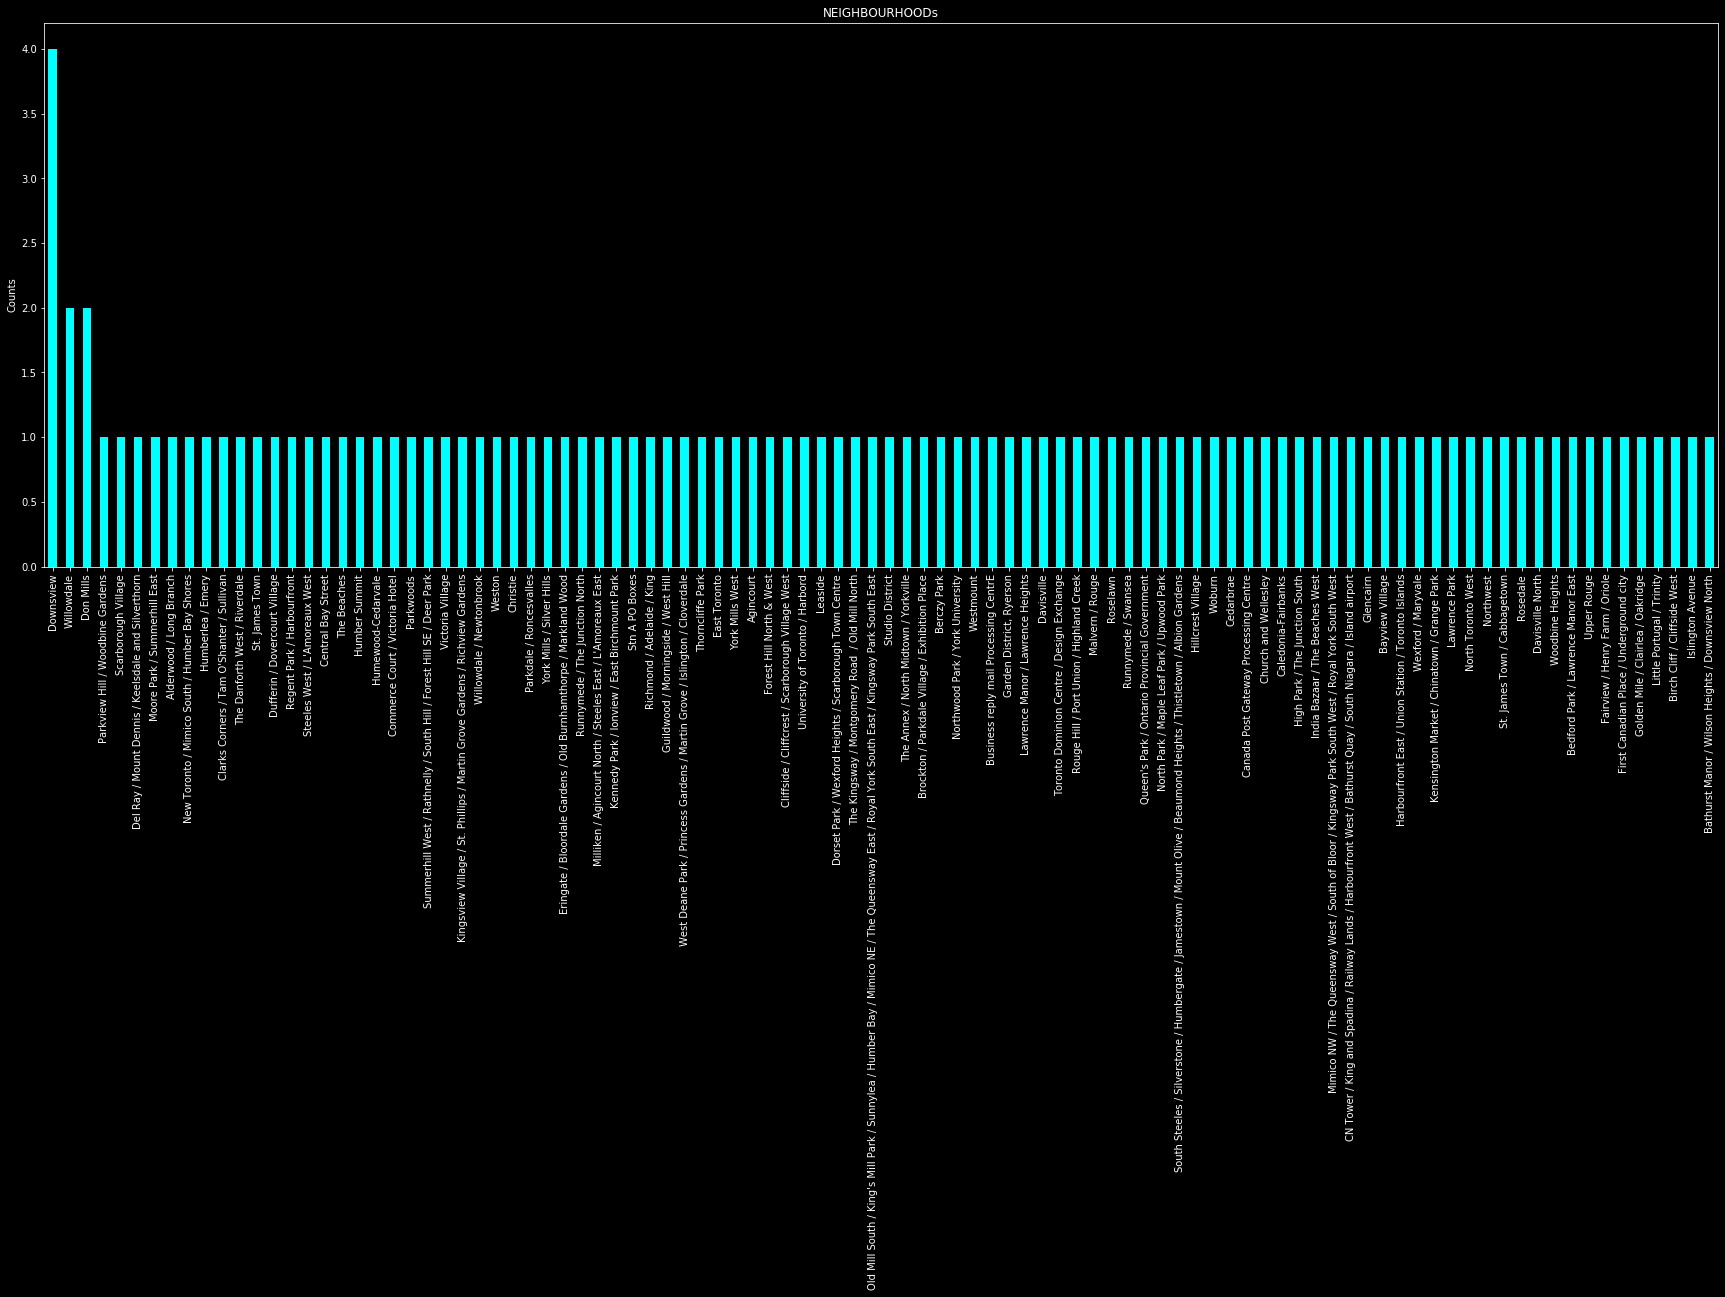

In [32]:
plt.style.use('dark_background')
tpcN.plot(kind = 'bar',stacked=True,grid=False,colormap='cool',figsize=(30,10))
plt.title('NEIGHBOURHOODs')
plt.ylabel('Counts')

Text(0.5, 0, 'Counts')

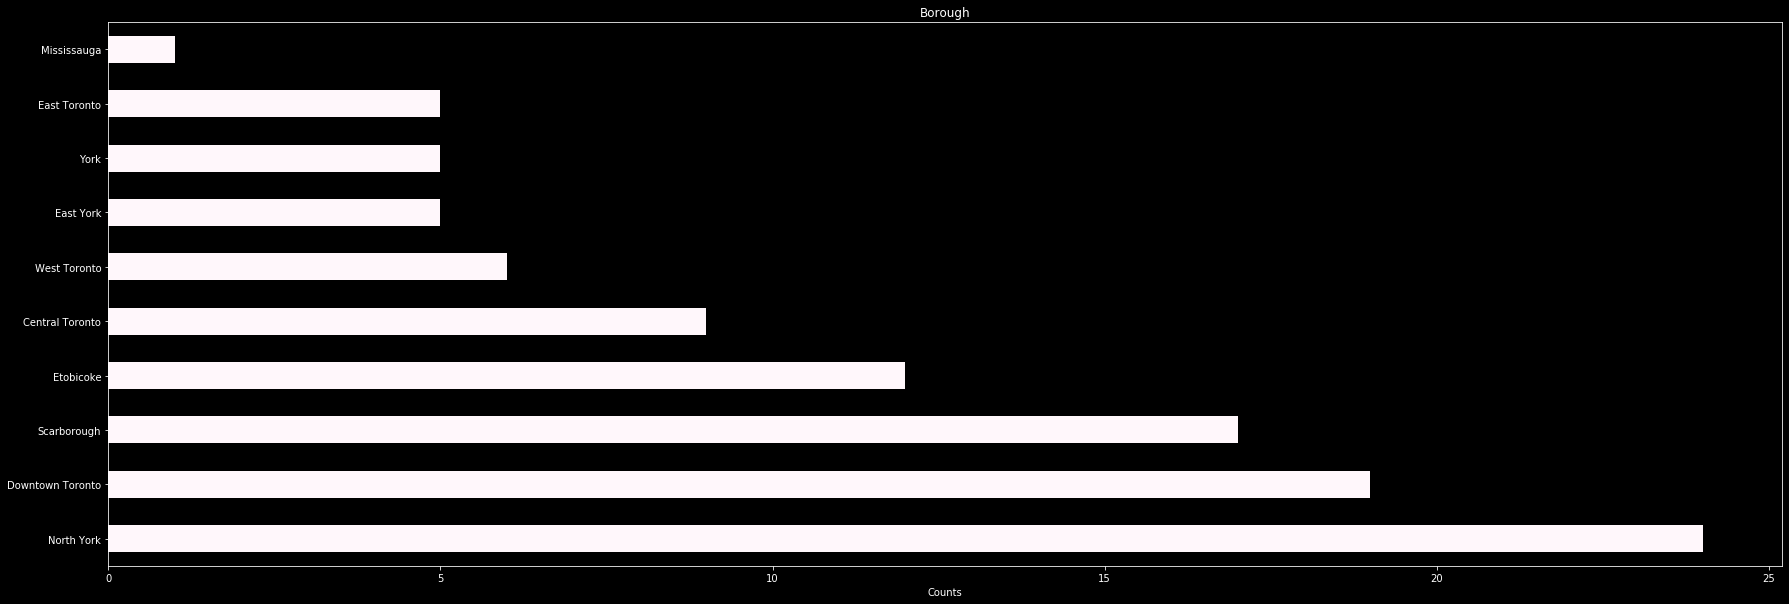

In [41]:
plt.style.use('dark_background')
tcpB.plot(kind = 'barh',stacked=True,grid=False,colormap='PuBu',figsize=(30,10))
plt.title('Borough')
plt.xlabel('Counts')

In [11]:
toronto_neighborhoods = pd.read_csv('Toronto.TASK_II_df.csv')

In [12]:
toronto_neighborhoods.head(5)

,Borough,Neighbourhood,Latitude,Longitude
0,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,Scarborough,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


In [13]:
#Using geopy library to get the latitude and longitude values of Toronto Canada
address = 'Toronto, Ontario Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto Canada are 43.6534817, -79.3839347.


In [14]:
# create map of Toronto using latitude and longitude values, with neighborhoods superimposed
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_neighborhoods['Latitude'], toronto_neighborhoods['Longitude'], toronto_neighborhoods['Borough'], toronto_neighborhoods['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='red',
        fill=True,
        fill_color='green',
        fill_opacity=0.5,
        parse_html=False).add_to(map_toronto)

In [15]:
map_toronto

In [16]:
# reduce the target analysis to Neighbohoods in East, West and Central Toronto i.e, we look at just a part, boroughs containing word Toronto.
toronto_data = toronto_neighborhoods[toronto_neighborhoods['Borough'].str.contains("Toronto")].reset_index(drop=True)
print(toronto_data.shape)
toronto_data.head(10)

(38, 4)


,Borough,Neighbourhood,Latitude,Longitude
0,East Toronto,The Beaches,43.676357,-79.293031
1,East Toronto,"Riverdale, The Danforth West",43.679557,-79.352188
2,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,East Toronto,Studio District,43.659526,-79.340923
4,Central Toronto,Lawrence Park,43.728020,-79.388790
5,Central Toronto,Davisville North,43.712751,-79.390197
6,Central Toronto,North Toronto West,43.715383,-79.405678
7,Central Toronto,Davisville,43.704324,-79.388790
8,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
9,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049


In [17]:
# redo the Map of Toronto, but here focus on the area of research, by using the same coordinates for the previous view
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        color='orange',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

<center><b>Methodology:
<p>At this stage we outline a step by step analytical walk through on the overall framework. It provides for a discussion and description of exploratory data analysis, inferential statistical testing conducted, and other methodological approaches. The k-means clustering algorithm will be used for the analysis. Fnally, use the Folium library to visualize the neighborhoods in Toronto and their emerging clusters

In [19]:
task1_data_csv = "Toronto.TASK_1_df.csv"
TorontoPostalCodes = pd.read_csv(task1_data_csv).set_index("Postcode")
TorontoPostalCodes.rename_axis("Postal Code", axis='index', inplace=True)
TorontoPostalCodes.head(5)

,Borough,Neighbourhood
Postal Code,,
M1B,Scarborough,"Malvern, Rouge"
M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill"
M1E,Scarborough,"Guildwood, Morningside, West Hill"
M1G,Scarborough,Woburn
M1H,Scarborough,Cedarbrae


<center><b>Retrieve and transform postal code coordinate values list:
 <p>We need to get the latitude and the longitude coordinates of each neighborhood. We are supposed to use the Google Maps Geocoding API to get the latitude and the longitude coordinates of each neighborhood.we will use the Geocoder Python package instead: https://geocoder.readthedocs.io/index.html.


In [20]:
toronto_geocsv = 'https://cocl.us/Geospatial_data'
!wget -q -O 'toronto_m.geospatial_data.csv' toronto_geocsv
geocsv_data = pd.read_csv(toronto_geocsv).set_index("Postal Code")
geocsv_data.head(5)

'wget' is not recognized as an internal or external command,
operable program or batch file.


,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


In [21]:
# combining Two data frames with mapped postcodes
toronto_neighborhoods = TorontoPostalCodes.join(geocsv_data)
toronto_neighborhoods.head(5)

,Borough,Neighbourhood,Latitude,Longitude
Postal Code,,,,
M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497
M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
M1G,Scarborough,Woburn,43.770992,-79.216917
M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [22]:
toronto_neighborhoods.to_csv('Toronto.TASK_II_df.csv',index=False)

In [23]:
toronto_neighborhoods.shape

(103, 4)

In [24]:
CLIENT_ID ='FOOTDKU1QVCC03J1DBQWRMXAG4FOLMDI12D2CCOF0X3CSLQT' # portion hidden from view' # your Foursquare ID
CLIENT_SECRET = 'LJK3O50TCWRM21XHNXGGCGJJHHIQNENVVFS5T2GBANBKUVVP'# portion hidden from view' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FOOTDKU1QVCC03J1DBQWRMXAG4FOLMDI12D2CCOF0X3CSLQT
CLIENT_SECRET:LJK3O50TCWRM21XHNXGGCGJJHHIQNENVVFS5T2GBANBKUVVP


<b>We begin by exploring Neighbourhood in Toronto, using the following foursquare api query url, search venues on all boroughs in selected Toronto neighborhoods

In [25]:
# The following function retrieves the venues given the names and coordinates and stores it into dataframe.
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
# The following function retrieves the venues given the names and coordinates and stores it into dataframe.
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
# Retrieve all venues given the Addresses
toronto_neighborhoods = toronto_data
toronto_venues = getNearbyVenues(names=toronto_neighborhoods['Neighbourhood'],
                                   latitudes=toronto_neighborhoods['Latitude'],
                                   longitudes=toronto_neighborhoods['Longitude']
                                  )

The Beaches
Riverdale, The Danforth West
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
North Midtown, The Annex, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
Bathurst Quay, CN Tower, Harbourfront West, Island airport, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

In [27]:
print(toronto_venues.shape)
toronto_venues.head(5)

(836, 7)


,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"Riverdale, The Danforth West",43.679557,-79.352188,MenEssentials,43.677820,-79.351265,Cosmetics Shop


In [28]:
# Count of venues were returned for each Borough
toronto_venues.groupby('Neighbourhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide, King, Richmond",30,30,30,30,30,30
"Bathurst Quay, CN Tower, Harbourfront West, Island airport, King and Spadina, Railway Lands, South Niagara",17,17,17,17,17,17
Berczy Park,30,30,30,30,30,30
"Brockton, Exhibition Place, Parkdale Village",23,23,23,23,23,23
Business Reply Mail Processing Centre 969 Eastern,18,18,18,18,18,18
"Cabbagetown, St. James Town",30,30,30,30,30,30
Central Bay Street,30,30,30,30,30,30
"Chinatown, Grange Park, Kensington Market",30,30,30,30,30,30
Christie,17,17,17,17,17,17


In [29]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Riverdale, The Danforth West",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
toronto_onehot.shape

(836, 193)

In [31]:
toronto_onehot.describe()

,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
count,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,...,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000
mean,0.001196,0.001196,0.001196,0.002392,0.003589,0.002392,0.009569,0.001196,0.001196,0.009569,...,0.001196,0.001196,0.004785,0.002392,0.011962,0.001196,0.005981,0.003589,0.001196,0.009569
std,0.034586,0.034586,0.034586,0.048882,0.059832,0.048882,0.097412,0.034586,0.034586,0.097412,...,0.034586,0.034586,0.069047,0.048882,0.108779,0.034586,0.077151,0.059832,0.034586,0.097412
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
#group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Bathurst Quay, CN Tower, Harbourfront West, Is...",0.058824,0.058824,0.058824,0.117647,0.176471,0.117647,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Brockton, Exhibition Place, Parkdale Village",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Business Reply Mail Processing Centre 969 Eastern,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556
5,"Cabbagetown, St. James Town",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.033333
7,"Chinatown, Grange Park, Kensington Market",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.066667,0.033333,0.000000,0.000000
8,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Church and Wellesley,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<b><center>Analysis and Results on Each Borough Neighborhood:

In [33]:
#Check new size:
toronto_grouped.shape

(38, 193)

In [34]:
#put that into a pandas dataframe
num_top_venues = 5
for neigh in toronto_grouped['Neighbourhood']:
    print("----"+neigh+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == neigh].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                venue  freq
0         Coffee Shop  0.10
1                Café  0.10
2  Seafood Restaurant  0.07
3         Opera House  0.03
4               Plaza  0.03


----Bathurst Quay, CN Tower, Harbourfront West, Island airport, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0   Airport Service  0.18
1    Airport Lounge  0.12
2  Airport Terminal  0.12
3           Airport  0.06
4               Bar  0.06


----Berczy Park----
                venue  freq
0  Seafood Restaurant  0.07
1        Cocktail Bar  0.07
2         Coffee Shop  0.07
3            Beer Bar  0.07
4   French Restaurant  0.03


----Brockton, Exhibition Place, Parkdale Village----
            venue  freq
0            Café  0.13
1  Breakfast Spot  0.09
2       Nightclub  0.09
3     Coffee Shop  0.09
4             Gym  0.04


----Business Reply Mail Processing Centre 969 Eastern----
                venue  freq
0         Yoga Studio  0.06
1                 Spa

In [35]:
# pass a function to Python to sort the locations in descending order, i.e A-Z.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
# create columns according to number of top venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.shape

(38, 11)

<center><b>Discussion and Observation

In [37]:
# Run k-means to cluster the neighborhood into 6 clusters 
# set number of clusters
kclusters = 10

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_[0:20])
print(len(kmeans.labels_))

[1 4 1 1 4 1 1 1 1 4 1 1 4 1 1 4 1 8 1 1]
38


In [38]:
toronto_neighborhoods.shape

(38, 4)

<center><b>We now have a framework through which we can make some determinations, that is, find the best place to locate a new business venture, for example, a resturant across Toronto

In [39]:
toronto_neighborhoods.head()

,Borough,Neighbourhood,Latitude,Longitude
0,East Toronto,The Beaches,43.676357,-79.293031
1,East Toronto,"Riverdale, The Danforth West",43.679557,-79.352188
2,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,East Toronto,Studio District,43.659526,-79.340923
4,Central Toronto,Lawrence Park,43.728020,-79.388790


<center><b>Conclusion and Recommendations:
<p>Now, we can finally do visualization of the clusters we produced above. By evaluation the clusters of the varous locatioins, we can better under the communities and dertermine where to locate

In [40]:
toronto_merged = toronto_neighborhoods

# add clustering labels
toronto_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() 

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,The Beaches,43.676357,-79.293031,1,Neighborhood,Trail,Pub,Health Food Store,Yoga Studio,Creperie,Dog Run,Distribution Center,Discount Store,Diner
1,East Toronto,"Riverdale, The Danforth West",43.679557,-79.352188,4,Greek Restaurant,Italian Restaurant,Ice Cream Shop,Yoga Studio,Pizza Place,Juice Bar,Bookstore,Restaurant,Spa,Dessert Shop
2,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,1,Sandwich Place,Fast Food Restaurant,Gym,Liquor Store,Ice Cream Shop,Steakhouse,Sushi Restaurant,Burrito Place,Fish & Chips Shop,Pizza Place
3,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,Bakery,Neighborhood,Middle Eastern Restaurant,Park,Pet Store,Cheese Shop,Coworking Space,Stationery Store
4,Central Toronto,Lawrence Park,43.728020,-79.388790,4,Park,Bus Line,Construction & Landscaping,Swim School,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner,Dessert Shop


In [41]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'],kmeans.labels_):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

<center><b>Conclusion:</b>
<p>Best Neighbourhood can b easily selected after examining the above 5 clusters.However East Toronto presents the best opportunity to be a first mover as well an early entrant into a community that is poised to experience phenomenal growth.